
level 1



In [41]:
!pip install -q datasets
from datasets import load_dataset
import json

# Load the dataset
dataset = load_dataset("roszcz/internship-midi-data-science", split="train")

# Convert to Python native dict
dataset_dict = dataset.to_dict()

# Save to json
with open('dataset.json', 'w') as fp:
    json.dump(dataset_dict, fp)



In [80]:
# Load the dataset from the JSON file
with open('/content/dataset.json', 'r') as fp:
    dataset_dict = json.load(fp)

# Convert the dataset_dict back to a DataFrame object
df = pd.DataFrame(dataset_dict)

In [83]:
print(df.head())


                                               notes  \
0  {'end': [2.0584375, 2.9904687500000002, 2.0445...   
1  {'end': [1.78125, 19.708333333333332, 20.02604...   
2  {'end': [2.927083333333333, 2.8854166666666665...   
3  {'end': [3.25625, 3.441145833333333, 4.334375,...   
4  {'end': [6.869791666666666, 6.895833333333333,...   

                                     control_changes user  record_id  
0  {'number': [64, 64, 64, 64, 64, 64, 64, 64, 64...   bb          3  
1  {'number': [64, 64, 64, 64, 64, 64, 64, 64, 64...   nk         60  
2  {'number': [64, 64, 64, 64, 64, 64, 64, 64, 64...   js         47  
3  {'number': [64, 64, 64, 64, 64, 64, 64, 64, 64...   ad         60  
4  {'number': [64, 64, 64, 64, 64, 64, 64, 64, 64...   tr         91  


In [44]:
from datasets import load_dataset
import json

# Load the dataset
dataset = load_dataset("roszcz/maestro-v1", split="train")

# Convert to Python native dict
dataset_dict = dataset.to_dict()

# Save to json
with open('maestro_dataset.json', 'w') as fp:
    json.dump(dataset_dict, fp)

In [86]:
print(df['notes'][0].keys())


dict_keys(['end', 'pitch', 'start', 'velocity'])


Speed:If the record is longer than 120 seconds, use minutes as the time unit.
Use "notes played per second" as the speed unit.

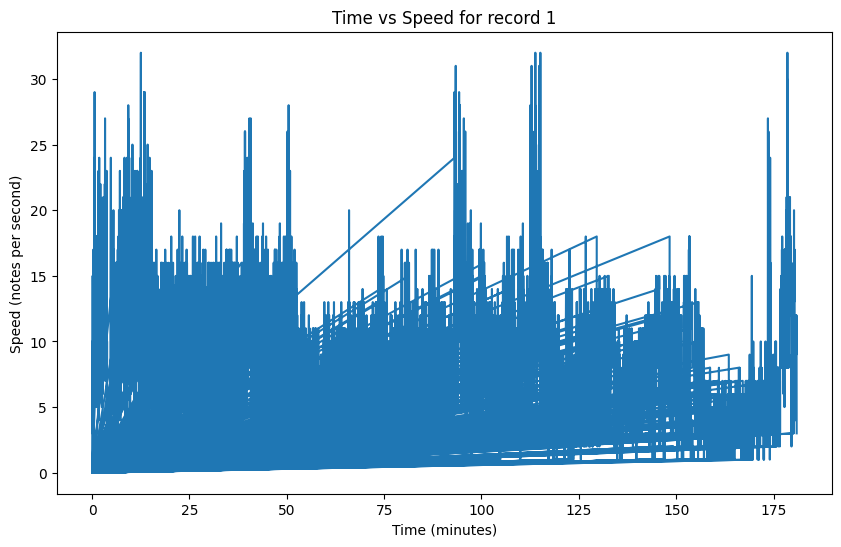

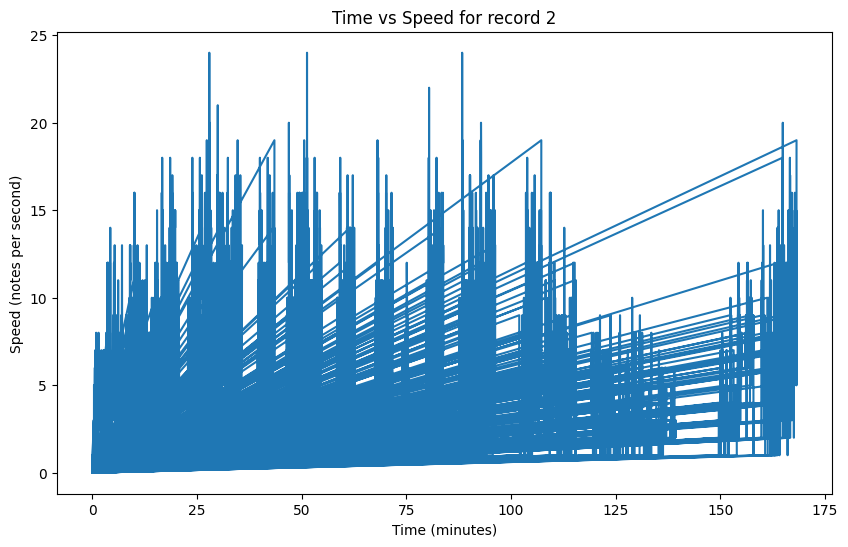

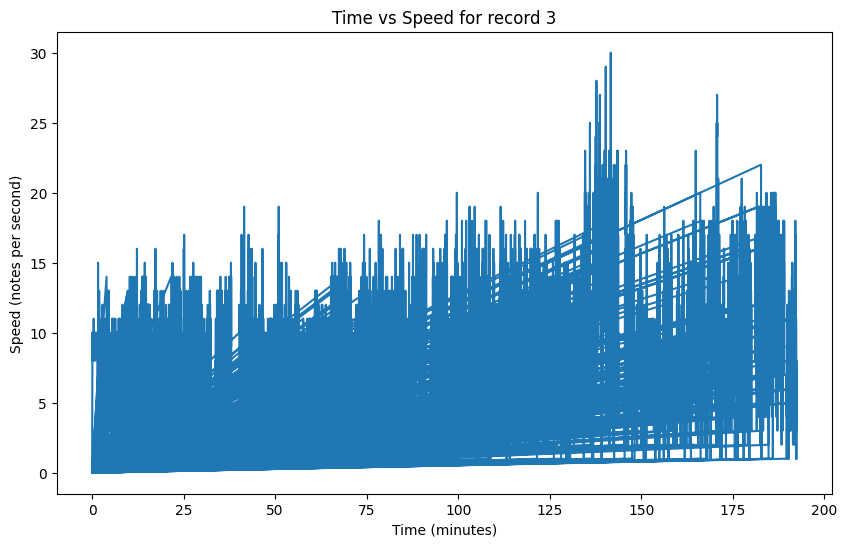

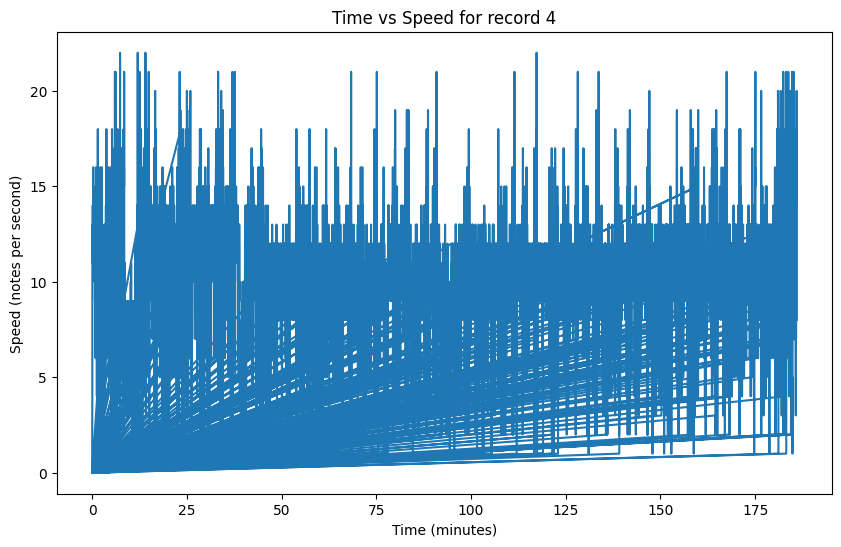

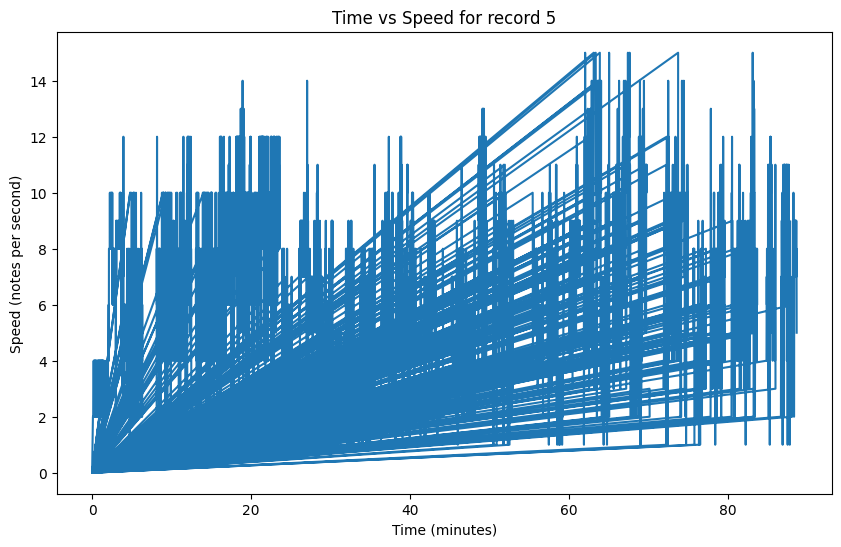

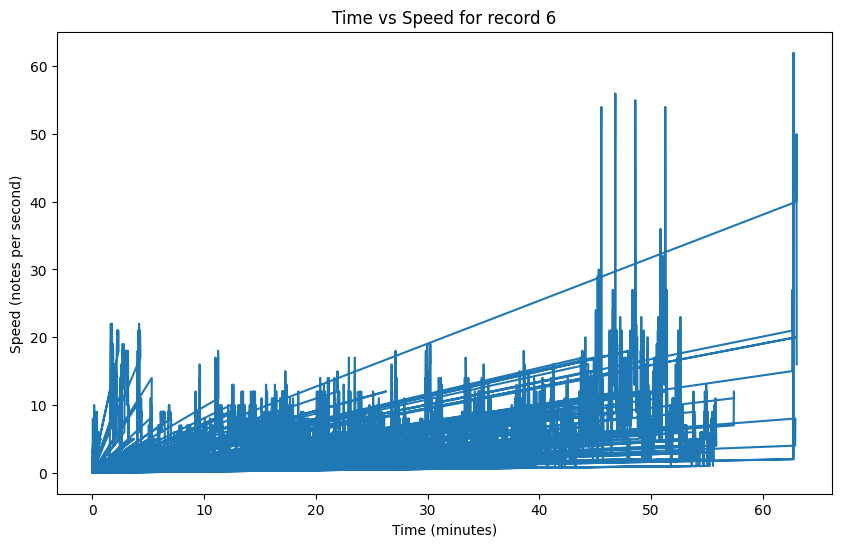

In [87]:

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the 'notes' data for this record
    notes_data = row['notes']

    # Extract the lists of start and end times from the 'notes' data
    start_times = notes_data['start']
    end_times = notes_data['end']

    # Calculate the duration of each note and the start time in seconds
    notes_df = pd.DataFrame({'start': start_times, 'end': end_times})
    notes_df['duration'] = notes_df['end'] - notes_df['start']
    notes_df['start_seconds'] = notes_df['start'].apply(lambda x: round(x))

    # Count the number of notes played in each second
    notes_per_second = notes_df.groupby('start_seconds').size()

    # Create a new DataFrame with one row per second (or minute)
    time_df = pd.DataFrame({'notes_per_second': notes_per_second})
    time_df['time'] = time_df.index
    time_df = time_df.reindex(np.arange(0, time_df['time'].max() + 1)).fillna(0)

    # If the record is longer than 120 seconds, use minutes as the time unit.
    if time_df['time'].max() > 120:
        time_df['time'] = time_df['time'] / 60
        time_label = 'Time (minutes)'
    else:
        time_label = 'Time (seconds)'

    # Plot time vs speed
    plt.figure(figsize=(10, 6))
    plt.plot(time_df['time'], time_df['notes_per_second'])
    plt.xlabel(time_label)
    plt.ylabel('Speed (notes per second)')
    plt.title(f'Time vs Speed for record {i+1}')
    plt.show()


Speed :Create a chart showing the number of notes pressed at the same time. Experiment with different thresholds.

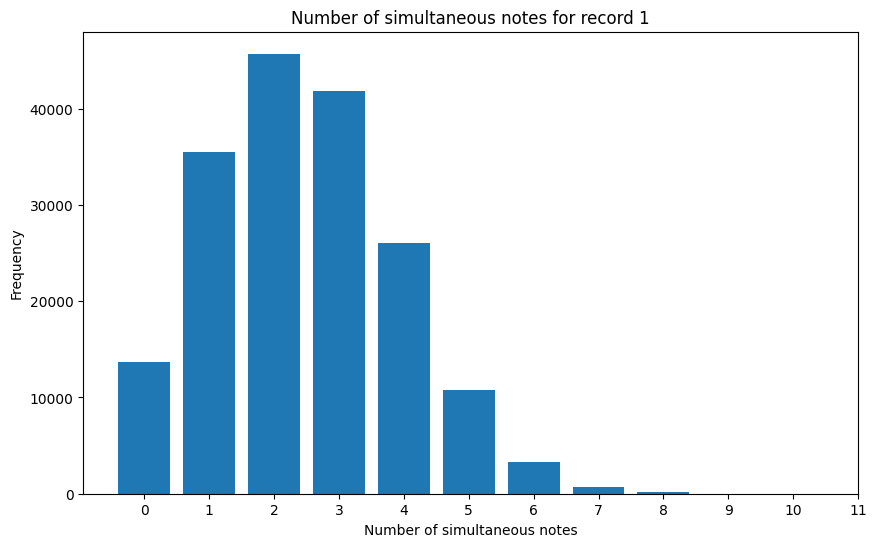

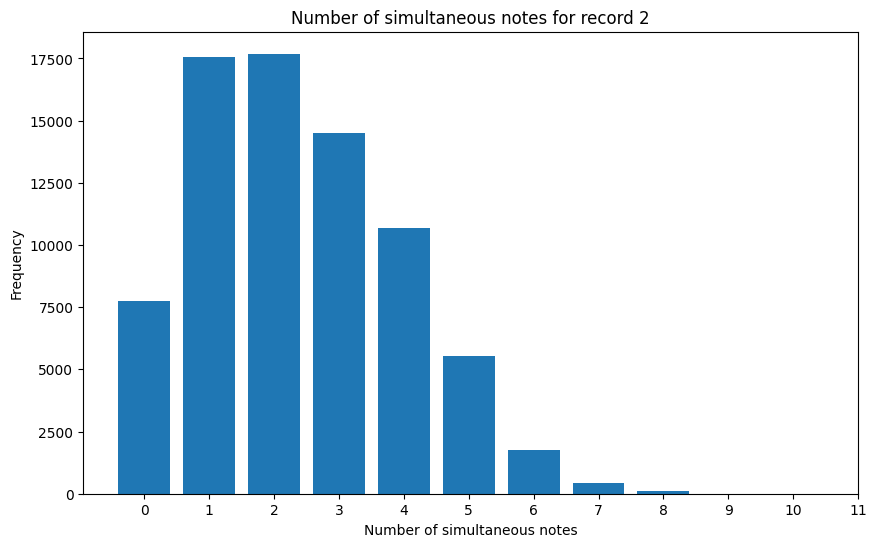

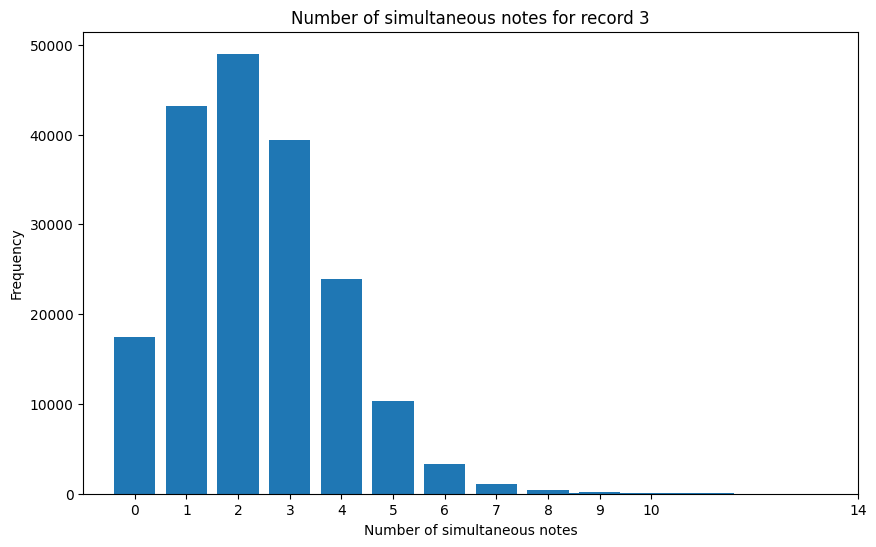

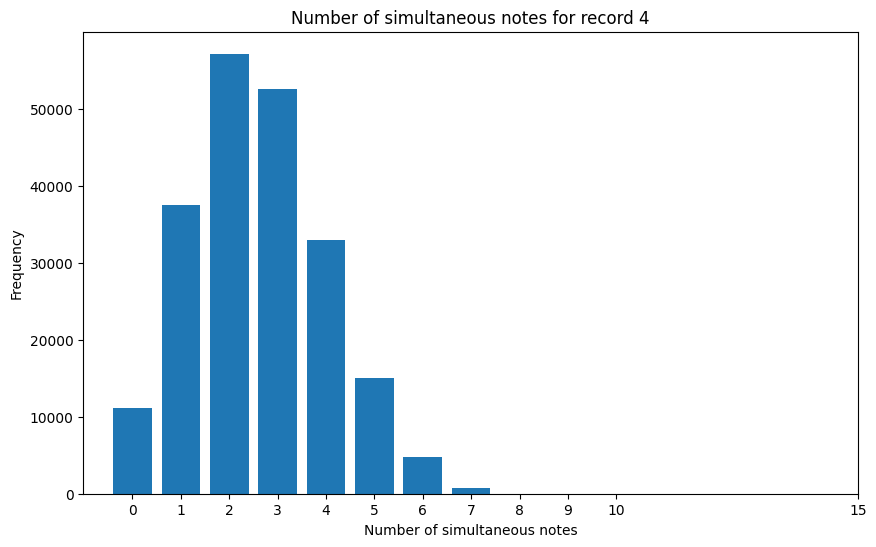

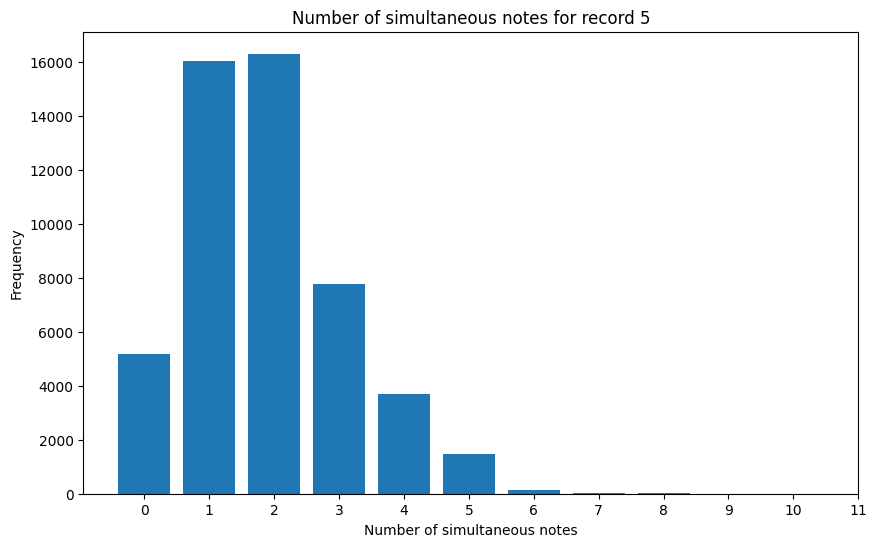

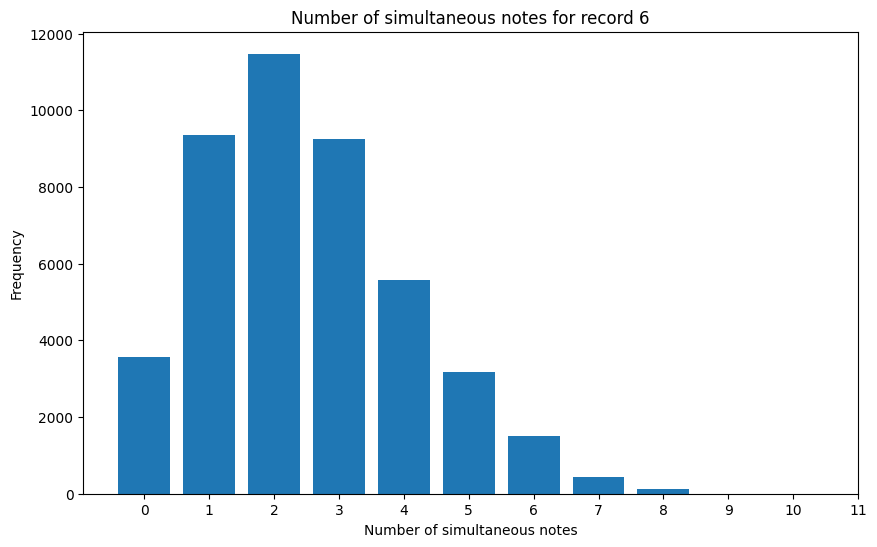

In [89]:
# Loop over each record in the DataFrame
# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the 'notes' data for this record
    notes_data = row['notes']

    # Extract the lists of start and end times from the 'notes' data
    start_times = notes_data['start']
    end_times = notes_data['end']

    # Create a DataFrame with all time points and the corresponding change in the number of active notes
    time_changes_df = pd.DataFrame({
        'time': start_times + end_times,
        'change': [1]*len(start_times) + [-1]*len(end_times)
    })

    # Sort by time
    time_changes_df = time_changes_df.sort_values('time')

    # Calculate the running sum of changes to get the number of active notes at each time point
    time_changes_df['active_notes'] = time_changes_df['change'].cumsum()

    # Set threshold for maximum number of simultaneous notes to group together
    threshold = 10

    # Adjust the bins parameter to group all instances with more than the threshold number of simultaneous notes together
    max_notes = time_changes_df['active_notes'].max()
    bins = list(range(0, threshold+1)) + [max_notes if max_notes > threshold else threshold+1]

    # Plot a histogram of the number of active notes
    plt.figure(figsize=(10, 6))
    plt.hist(time_changes_df['active_notes'], bins=bins, align='left', rwidth=0.8)
    plt.xlabel('Number of simultaneous notes')
    plt.ylabel('Frequency')
    plt.title(f'Number of simultaneous notes for record {i+1}')
    plt.xticks(bins)
    plt.show()


Chords: For a given record, create a chart of time vs. the number of chords played.

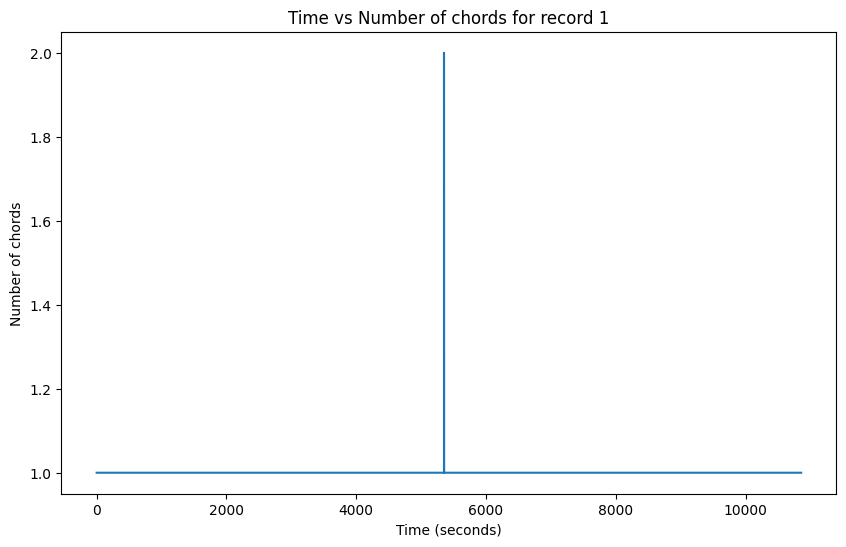

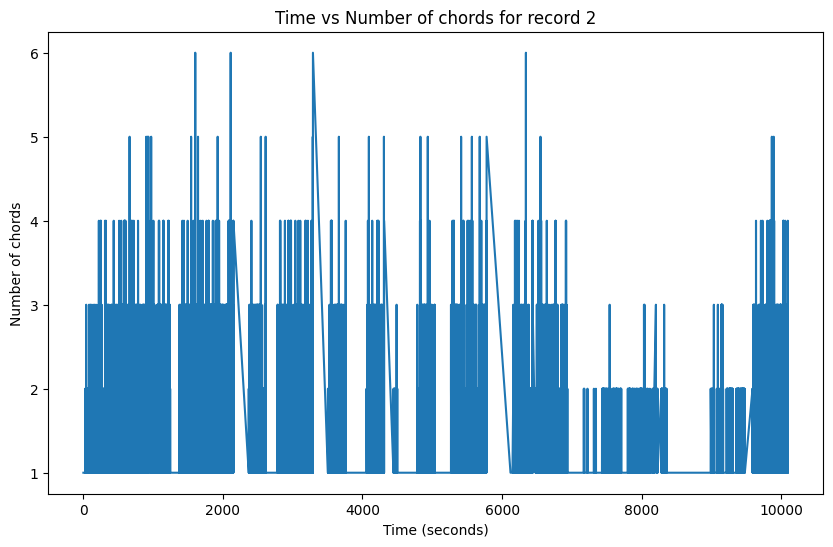

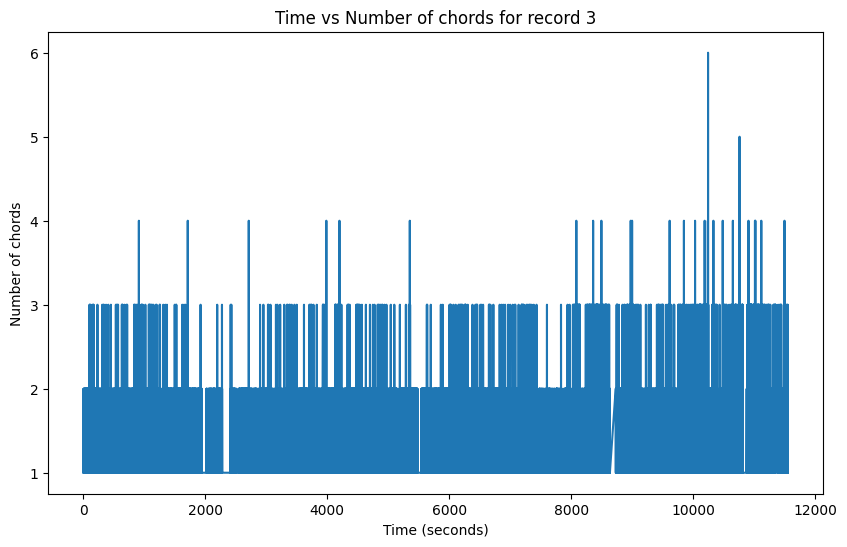

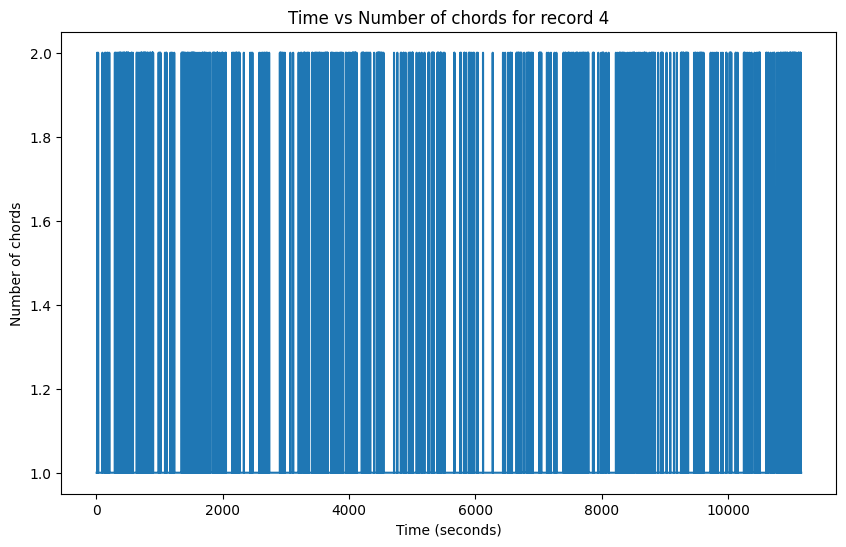

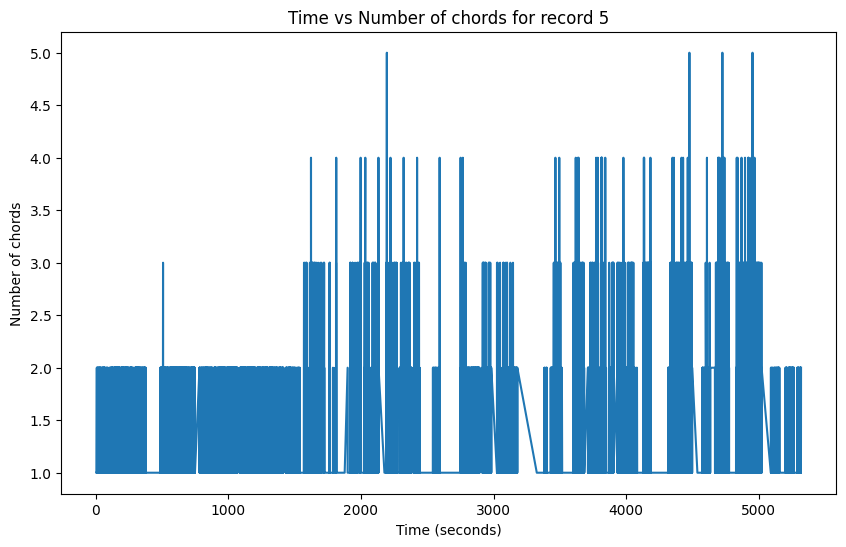

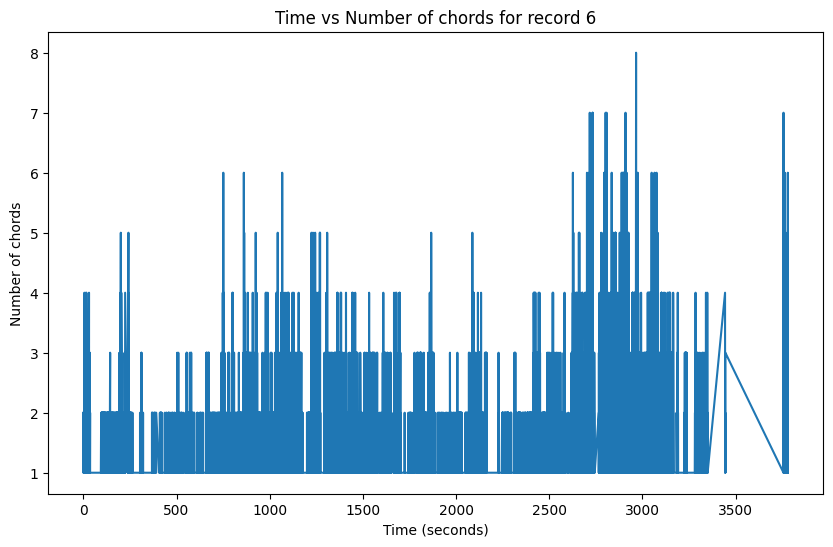

In [91]:
# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the 'notes' data for this record
    notes_data = row['notes']

    # Extract the lists of start and end times from the 'notes' data
    start_times = notes_data['start']

    # Create a DataFrame with start times
    start_times_df = pd.DataFrame({'start': start_times})

    # Count the number of notes starting at each time point
    chords_df = start_times_df['start'].value_counts().reset_index()
    chords_df.columns = ['time', 'chords']

    # Sort by time
    chords_df = chords_df.sort_values('time')

    # Plot time vs chords
    plt.figure(figsize=(10, 6))
    plt.plot(chords_df['time'], chords_df['chords'])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of chords')
    plt.title(f'Time vs Number of chords for record {i+1}')
    plt.show()


Chords:Based on chord detection developed for 1., crate a table with the number of occurances of chords.

In [92]:
import pandas as pd



# Create an empty dictionary to store chord occurrences
chord_occurrences = {}

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the 'notes' data for this record
    notes_data = row['notes']

    # Extract the lists of start and end times from the 'notes' data
    start_times = notes_data['start']

    # Count the number of occurrences of each chord
    for chord_time in start_times:
        if chord_time in chord_occurrences:
            chord_occurrences[chord_time] += 1
        else:
            chord_occurrences[chord_time] = 1

# Convert the dictionary to a DataFrame
chord_occurrences_df = pd.DataFrame(chord_occurrences.items(), columns=['Chord', 'Occurrences'])

# Sort the DataFrame by time
chord_occurrences_df = chord_occurrences_df.sort_values('Chord')

# Reset the index of the DataFrame
chord_occurrences_df = chord_occurrences_df.reset_index(drop=True)

# Display the table
print(chord_occurrences_df)


               Chord  Occurrences
0           0.000000            2
1           0.135417            1
2           0.932292            1
3           1.125000            1
4           1.171875            1
...              ...          ...
346808  11548.963542            2
346809  11548.984375            2
346810  11549.000000            1
346811  11549.239583            1
346812  11549.640625            1

[346813 rows x 2 columns]


In [105]:
# Load the dataset from the JSON file
with open('/content/maestro_dataset.json', 'r') as fp:
    dataset_dict = json.load(fp)

# Convert the dataset_dict back to a DataFrame object
df_maestro = pd.DataFrame(dataset_dict)

# Display the DataFrame
df_maestro.head()


,notes,control_changes,composer,title,year,midi_filename
0,"{'duration': [0.8268229166666666, 0.1223958333...","{'number': [64, 64, 64, 64, 64, 64, 64, 64, 64...",Alban Berg,Sonata Op. 1,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...
1,"{'duration': [0.8971354166666667, 0.45703125, ...","{'number': [64, 67, 64, 64, 64, 64, 64, 64, 64...",Alban Berg,Sonata Op. 1,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...
2,"{'duration': [0.8458333333333334, 0.384375, 1....","{'number': [64, 67, 64, 64, 64, 64, 64, 64, 64...",Alban Berg,Sonata Op. 1,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...
3,"{'duration': [1.7427083333333333, 1.9947916666...","{'number': [64, 67, 64, 64, 64, 64, 64, 64, 64...",Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...
4,"{'duration': [0.5390625, 0.5768229166666667, 0...","{'number': [64, 66, 67, 64, 64, 64, 64, 64, 64...",Alexander Scriabin,"Etude Op. 2 No.1; Etudes Op. 8, Nos. 5, 11 an...",2013,2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_...


Using solutions you developed, review this dataset: https://huggingface.co/datasets/roszcz/maestro-v1, and find:

A piece with the fastest 15 seconds of music

In [106]:
# Task 1: Fastest 15 seconds of music
# Calculate the number of notes played in each 15-second window, then find the window with the highest count

def calculate_notes_in_window(start_times, window_size=15):
    """
    Calculate the number of notes played in each window of size `window_size` seconds.

    Parameters:
    start_times (list): List of note start times
    window_size (int): Size of the window in seconds

    Returns:
    dict: A dictionary with keys as the start time of each window and values as the number of notes in the window
    """
    # Initialize the dictionary to store the number of notes in each window
    notes_in_window = {}

    # Loop over the start times
    for start_time in start_times:
        # Calculate the window start time
        window_start_time = start_time - (start_time % window_size)

        # If this window is not yet in the dictionary, add it
        if window_start_time not in notes_in_window:
            notes_in_window[window_start_time] = 0

        # Increment the count of notes in this window
        notes_in_window[window_start_time] += 1

    return notes_in_window

# Initialize the variables to store the record with the fastest 15 seconds of music
max_notes = 0
max_notes_record = None

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the 'notes' data for this record
    notes_data = row['notes']

    # Extract the lists of start and end times from the 'notes' data
    start_times = notes_data['start']

    # Calculate the number of notes in each 15-second window
    notes_in_window = calculate_notes_in_window(start_times)

    # If this record has a window with more notes than the current maximum, update the maximum
    record_max_notes = max(notes_in_window.values())
    if record_max_notes > max_notes:
        max_notes = record_max_notes
        max_notes_record = i

max_notes, max_notes_record


(324, 5)

The output (324, 5) implies that the highest number of notes played within any 15-second window in the entire dataset is 324 notes. This occurs in the 6th record of your dataset (indexing starts from 0), which is identified by the number 5.

In [107]:
# from collections import Counter

# # Loop over each record in the DataFrame
# chord_occurrences = {}
# for i, row in df_maestro.iterrows():
#     # Extract the list of start times and pitches for this record
#     start_times = row['notes']['start']
#     pitches = row['notes']['pitch']

#     # Combine the start times and pitches into a single list of tuples
#     notes = list(zip(start_times, pitches))

#     # Sort the list of notes by start time
#     notes.sort(key=lambda x: x[0])

#     # Group notes that start at the same time to form chords
#     chords = []
#     chord = [notes[0]]
#     for note in notes[1:]:
#         if note[0] == chord[0][0]:
#             chord.append(note)
#         else:
#             chords.append(tuple(sorted(chord)))  # Sort the notes in the chord and convert to tuple
#             chord = [note]
#     chords.append(tuple(sorted(chord)))  # Add the last chord

#     # Count the number of occurrences of each chord
#     chord_counts = Counter(chords)

#     # Find the chord with the most occurrences in this piece
#     most_common_chord, count = chord_counts.most_common(1)[0]

#     # If this piece has a chord with more occurrences than the current maximum, update the maximum
#     if count > chord_occurrences.get('count', 0):
#         chord_occurrences = {'piece': i, 'chord': most_common_chord, 'count': count}

# chord_occurrences


In [102]:
# from collections import Counter

# # Loop over each record in the DataFrame
# chord_occurrences = {}
# for i, row in df_maestro.iterrows():
#     # Extract the list of start times and pitches for this record
#     start_times = row['notes']['start']
#     pitches = row['notes']['pitch']

#     # Combine the start times and pitches into a single list of tuples
#     notes = list(zip(start_times, pitches))

#     # Sort the list of notes by start time
#     notes.sort(key=lambda x: x[0])

#     # Group notes that start at the same time to form chords
#     chords = []
#     chord = [notes[0]]
#     for note in notes[1:]:
#         if note[0] == chord[0][0]:
#             chord.append(note)
#         else:
#             chords.append(tuple(sorted(chord)))  # Sort the notes in the chord and convert to tuple
#             chord = [note]
#     chords.append(tuple(sorted(chord)))  # Add the last chord

#     # Count the number of occurrences of each chord
#     chord_counts = Counter(chords)

#     # Store the chord that is repeated the most in this piece
#     chord_occurrences[i] = chord_counts.most_common(1)[0]


In [64]:
# from collections import Counter
# # Loop over each record in the DataFrame
# chord_occurrences = {}
# for i, row in df_maestro.iterrows():
#     # Extract the list of start times and pitches for this record
#     start_times = row['notes']['start']
#     pitches = row['notes']['pitch']

#     # Combine the start times and pitches into a single list of tuples
#     notes = list(zip(start_times, pitches))

#     # Sort the list of notes by start time
#     notes.sort(key=lambda x: x[0])

#     # Group notes that start at the same time to form chords
#     chords = []
#     chord = [notes[0]]
#     for note in notes[1:]:
#         if note[0] == chord[0][0]:
#             chord.append(note)
#         else:
#             chords.append(tuple(sorted(chord)))  # Sort the notes in the chord and convert to tuple
#             chord = [note]
#     chords.append(tuple(sorted(chord)))  # Add the last chord

#     # Count the number of occurrences of each chord
#     chord_counts = Counter(chords)

#     # Find the most common chord in this piece
#     most_common_chord = chord_counts.most_common(1)[0]

#     # Store the most common chord and its count
#     chord_occurrences[i] = most_common_chord

# # Find the piece with the most repeated chord
# max_chord_count = max(chord_occurrences.items(), key=lambda x: x[1][1])

# # Print the piece and the most repeated chord
# print(f"Piece {max_chord_count[0]} has the most repeated chord {max_chord_count[1][0]} with {max_chord_count[1][1]} occurrences.")

Piece 0 has the most repeated chord ((0.9830729166666666, 67),) with 1 occurrences.


A piece where a single chord is repeated the most (each piece will have a different chord)

In [108]:
from collections import Counter

# Assuming you have the DataFrame 'df' with the 'notes' column

# Create an empty dictionary to store chord occurrences for each piece
piece_chord_occurrences = {}

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the list of start times for this record
    start_times = row['notes']['start']

    # Count the number of occurrences of each chord in this piece
    chord_occurrences = Counter(start_times)

    # Find the chord that has the most occurrences in this piece
    most_common_chord, count = chord_occurrences.most_common(1)[0]

    # Store the most common chord and its count in the dictionary
    piece_chord_occurrences[i] = {'chord': most_common_chord, 'count': count}

# Convert the dictionary to a DataFrame
piece_chord_occurrences_df = pd.DataFrame(piece_chord_occurrences.values(), index=piece_chord_occurrences.keys())

# Add the piece index as a column
piece_chord_occurrences_df['piece'] = piece_chord_occurrences_df.index

# Display the table
print(piece_chord_occurrences_df)


          chord  count  piece
0   5353.934271      2      0
1   1603.854167      6      1
2  10240.484375      6      2
3     10.072396      2      3
4   2195.489583      5      4
5   2965.880208      8      5


In [ ]:
#level 2

For a given record, find the most popular 2-grams, 3-grams, and 4-grams.
Use 12 tokens corresponding to the 12 tones of an octave. Treat pitches an octave apart as the same token.
Use 88 tokens corresponding to the 88 keys of the piano.

In [109]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Function to find the most popular n-grams in a pitch sequence
def find_most_popular_ngrams(pitches, n, num_tokens):
    # Create a CountVectorizer object for n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n), token_pattern=r"(?u)\b\w+\b")

    # Tokenize the pitches and convert to a string
    pitch_string = ' '.join([str(pitch % num_tokens) for pitch in pitches])

    # Count the occurrences of each n-gram
    ngram_counts = vectorizer.fit_transform([pitch_string]).toarray()[0]

    # Get the list of n-grams
    ngrams = vectorizer.get_feature_names_out()

    # Find the most common n-grams
    most_common_ngrams = [ngrams[i] for i in ngram_counts.argsort()[::-1]]

    return most_common_ngrams

# Load the dataset from the JSON file
with open('/content/dataset.json', 'r') as fp:
    dataset_dict = json.load(fp)

# Convert the dataset_dict back to a DataFrame object
df = pd.DataFrame(dataset_dict)

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the pitch sequence for this record
    pitches = row['notes']['pitch']

    # Find the most popular 2-grams, 3-grams, and 4-grams using 12 tokens
    for n in [2, 3, 4]:
        most_common_ngrams = find_most_popular_ngrams(pitches, n, 12)
        print(f'Most popular {n}-grams for record {i} using 12 tokens: {most_common_ngrams[:5]}')

    # Find the most popular 2-grams, 3-grams, and 4-grams using 88 tokens
    for n in [2, 3, 4]:
        most_common_ngrams = find_most_popular_ngrams(pitches, n, 88)
        print(f'Most popular {n}-grams for record {i} using 88 tokens: {most_common_ngrams[:5]}')


Most popular 2-grams for record 0 using 12 tokens: ['9 9', '4 4', '2 2', '5 5', '9 4']
Most popular 3-grams for record 0 using 12 tokens: ['9 9 9', '9 4 4', '9 9 4', '9 2 2', '4 4 9']
Most popular 4-grams for record 0 using 12 tokens: ['9 9 9 9', '9 9 4 4', '9 9 2 2', '0 0 9 9', '9 4 4 9']
Most popular 2-grams for record 0 using 88 tokens: ['45 57', '57 45', '64 52', '52 64', '60 48']
Most popular 3-grams for record 0 using 88 tokens: ['48 45 57', '52 60 48', '64 52 60', '60 48 45', '50 62 53']
Most popular 4-grams for record 0 using 88 tokens: ['60 48 45 57', '64 52 60 48', '50 62 53 65', '53 65 64 52', '65 64 52 60']
Most popular 2-grams for record 1 using 12 tokens: ['7 9', '5 7', '0 2', '2 5', '9 7']
Most popular 3-grams for record 1 using 12 tokens: ['5 7 9', '9 7 5', '0 2 4', '7 9 7', '10 7 2']
Most popular 4-grams for record 1 using 12 tokens: ['2 4 5 7', '5 7 9 7', '2 0 2 0', '0 2 4 5', '0 2 0 2']
Most popular 2-grams for record 1 using 88 tokens: ['65 67', '67 69', '69 67', '6

Find n-grams based on note distance instead of pitch
Note distance is the time between start for note a and the start of the next note b (it's not duration).
Experiment with different numbers of tokens used to quantize the note distance. Choose one value and make a case for it.

In [110]:
from sklearn.preprocessing import KBinsDiscretizer

def calculate_note_distances(start_times):
    """Calculate the distances between the start times of consecutive notes."""
    note_distances = [start_times[i+1] - start_times[i] for i in range(len(start_times) - 1)]
    return note_distances

def find_most_popular_ngrams_based_on_distance(start_times, n, num_bins):
    """Find the most popular n-grams in a sequence of note distances."""

    # Calculate the note distances
    note_distances = calculate_note_distances(start_times)

    # Quantize the note distances into a number of bins
    kb = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
    quantized_note_distances = kb.fit_transform(np.array(note_distances).reshape(-1, 1)).flatten().astype(int)

    # Create a CountVectorizer object for n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n), token_pattern=r"(?u)\b\w+\b")

    # Tokenize the quantized note distances and convert to a string
    distance_string = ' '.join(map(str, quantized_note_distances))

    # Count the occurrences of each n-gram
    ngram_counts = vectorizer.fit_transform([distance_string]).toarray()[0]

    # Get the list of n-grams
    ngrams = vectorizer.get_feature_names_out()

    # Find the most common n-grams
    most_common_ngrams = [ngrams[i] for i in ngram_counts.argsort()[::-1]]

    return most_common_ngrams


In [111]:
# Load the dataset from the JSON file
with open('/content/dataset.json', 'r') as fp:
    dataset_dict = json.load(fp)

# Convert the dataset_dict back to a DataFrame object
df = pd.DataFrame(dataset_dict)

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the start times for this record
    start_times = row['notes']['start']

    # Find the most popular 2-grams, 3-grams, and 4-grams using 10 bins
    for n in [2, 3, 4]:
        most_common_ngrams = find_most_popular_ngrams_based_on_distance(start_times, n, 10)
        print(f'Most popular {n}-grams for record {i} using 10 bins: {most_common_ngrams[:5]}')



Most popular 2-grams for record 0 using 10 bins: ['0 0', '0 1', '1 0', '0 2', '2 0']
Most popular 3-grams for record 0 using 10 bins: ['0 0 0', '0 1 0', '1 0 0', '0 0 1', '2 0 0']
Most popular 4-grams for record 0 using 10 bins: ['0 0 0 0', '0 0 1 0', '0 1 0 0', '0 0 0 1', '1 0 0 0']
Most popular 2-grams for record 1 using 10 bins: ['0 0', '3 0', '0 3', '2 0', '0 2']
Most popular 3-grams for record 1 using 10 bins: ['0 0 0', '3 0 0', '0 0 3', '0 3 0', '2 0 0']
Most popular 4-grams for record 1 using 10 bins: ['0 0 0 0', '0 0 0 3', '0 0 3 0', '3 0 0 0', '0 3 0 0']
Most popular 2-grams for record 2 using 10 bins: ['0 0', '1 0', '0 1', '2 0', '0 2']
Most popular 3-grams for record 2 using 10 bins: ['0 0 0', '0 1 0', '0 0 1', '1 0 0', '0 0 2']
Most popular 4-grams for record 2 using 10 bins: ['0 0 0 0', '0 0 0 1', '1 0 0 0', '0 1 0 0', '0 0 1 0']
Most popular 2-grams for record 3 using 10 bins: ['0 0', '0 1', '1 0', '2 0', '0 2']
Most popular 3-grams for record 3 using 10 bins: ['0 0 0', '

level 3 :Given a sequence of notes, find similar sequences inside all available records. Sort by similarity.
Propose at least 2 different similarity metrics to compare sequences.

In [112]:
import json
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Load the dataset from the JSON file
with open('/content/dataset.json', 'r') as fp:
    dataset_dict = json.load(fp)

# Convert the dataset_dict back to a DataFrame object
df = pd.DataFrame(dataset_dict)

# Function to convert a sequence of notes to a string
def sequence_to_string(sequence):
    return ' '.join(str(note) for note in sequence)

# Function to calculate Jaccard similarity between two sequences
def jaccard_similarity(sequence1, sequence2):
    set1 = set(sequence1)
    set2 = set(sequence2)
    return len(set1 & set2) / len(set1 | set2)

# Function to calculate Cosine similarity between two sequences
def calculate_cosine_similarity(sequence1, sequence2):
    vectorizer = CountVectorizer().fit_transform([sequence1, sequence2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0,1]

# Target sequence of notes
target_sequence = [60, 62, 64, 65]
target_string = sequence_to_string(target_sequence)

# Dictionary to store the similarity of each sequence to the target sequence
similarities = {}

# Loop over each record in the DataFrame
for i, row in df.iterrows():
    # Extract the pitch sequence for this record and convert to a string
    pitch_sequence = row['notes']['pitch']
    pitch_string = sequence_to_string(pitch_sequence)

    # Calculate the Jaccard and Cosine similarities to the target sequence
    jaccard_sim = jaccard_similarity(target_string, pitch_string)
    cosine_sim = calculate_cosine_similarity(target_string, pitch_string)

    # Store the similarities in the dictionary
    similarities[i] = {'Jaccard': jaccard_sim, 'Cosine': cosine_sim}

# Convert the dictionary to a DataFrame
similarities_df = pd.DataFrame(similarities.values(), index=similarities.keys())

# Add the record index as a column
similarities_df['record'] = similarities_df.index

# Sort the DataFrame by Jaccard similarity and then by Cosine similarity
similarities_df = similarities_df.sort_values(['Jaccard', 'Cosine'], ascending=False)

# Display the table
print(similarities_df)


    Jaccard    Cosine  record
1  0.545455  0.536401       1
2  0.545455  0.454883       2
4  0.545455  0.416621       4
5  0.545455  0.414175       5
0  0.545455  0.390652       0
3  0.545455  0.301554       3
